In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from src.logger import logger

In [3]:
def load_data(filepath):
    """Safely load data from CSV, handling common errors."""
    try:
        data = pd.read_csv(filepath)
        if data.empty:
            logger.warning(f"Warning: {filepath} is empty.")
            return None
        return data
    except FileNotFoundError:
        logger.error(f"Error: File {filepath} not found.")
        return None
    except pd.errors.EmptyDataError:
        logger.error(f"Error: File {filepath} is empty, no data to load.")
        return None
    except Exception as e:
        logger.error(f"An unexpected error occurred: {e}")
        return None

def calculate_electrode_counts_networks(data):
    """Calculates the percentage of electrodes for specified power changes across networks."""

    # Check if the input data is None or empty
    if data is None or data.empty:
        # If data is empty or None, return default values for each network type
        return {'fpn_increase': 0, 'fpn_decrease': 0, 'non_fpn_increase': 0, 'non_fpn_decrease': 0}

    # Filter the data to only include rows where the p-value is less than or equal to 0.051 (significant data)
    sig_data = data[data['p-value'] <= 0.05]

    # Calculate the total number of significant electrodes
    total_sig = len(sig_data)

    # List of non-FPN networks
    non_fpn_networks = ['DMN', 'CON', 'motor']

    # Initialize a dictionary to store the results of percentage calculations for each category
    results = {
        # Calculate percentage of FPN electrodes with significant increase in power
        'fpn_increase': (len(sig_data[(sig_data['Network'] == 'FPN') & (sig_data['PSC'] >= 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of FPN electrodes with significant decrease in power
        'fpn_decrease': (len(sig_data[(sig_data['Network'] == 'FPN') & (sig_data['PSC'] < 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of non-FPN electrodes (e.g. DMN, CON, motor) with significant increase in power
        'non_fpn_increase': (len(sig_data[(sig_data['Network'].isin(non_fpn_networks)) & (sig_data['PSC'] > 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of non-FPN electrodes (e.g. DMN, CON, motor) with significant decrease in power
        'non_fpn_decrease': (len(sig_data[(sig_data['Network'].isin(non_fpn_networks)) & (sig_data['PSC'] < 0)]) / total_sig) * 100 if total_sig > 0 else 0,
    }

    # Return the results as a dictionary with percentage values for each category
    return results


def calculate_net_changes(data):
    """Calculate net changes for significant electrodes by network and band."""
    # Categorize each electrode into 'FPN' or 'non-FPN' based on the 'Network' column.
    # This uses a lambda function to check if 'FPN' is part of the network name.
    data['Network Type'] = data['Network'].apply(lambda x: 'FPN' if 'FPN' in x else 'non-FPN')

    # Filter data to include only rows where the p-value indicates significance (p < 0.05).
    sig_data = data[data['p-value'] < 0.05]

    # Initialize a dictionary to store the results.
    results = {}

    # Group the significant data by 'Network Type' and 'Band', then iterate over each group.
    for (network, band), group in sig_data.groupby(['Network Type', 'Band']):
        # Calculate the average increase in PSC where the PSC is positive.
        # If there are no positive PSC values, default to 0.
        increase_avg = group[group['PSC'] > 0]['PSC'].mean() if not group[group['PSC'] > 0]['PSC'].empty else 0

        # Calculate the average decrease in PSC where the PSC is negative.
        # If there are no negative PSC values, default to 0.
        decrease_avg = group[group['PSC'] < 0]['PSC'].mean() if not group[group['PSC'] < 0]['PSC'].empty else 0

        # Calculate net change as the sum of the average increase and decrease.
        net_change = increase_avg + decrease_avg

        # Store the net change in the results dictionary under the appropriate network and band.
        results.setdefault(network, {})[band] = net_change

    # Return the results dictionary containing net changes for all significant electrodes
    # categorized by network type and band.
    return results


def calculate_average_changes(data):
    """Calculate the average changes for significant electrodes per network across all bands."""
    # Check if the filtered data is not empty to proceed with the calculation.
    if not data.empty:
        # Group HG data by the 'Network' column and calculate the mean of the 'PSC' values for each network
        return data_hg.groupby('Network')['PSC'].mean().reset_index()
        # The reset_index() function is used to transform the resulting Series into a DataFrame and provide
        # a clean index. This DataFrame will have two columns: 'Network' and the average 'PSC'.

    # If the filtered data is empty return an empty DataFrame  with the columns 'Network' and 'PSC'.
    return pd.DataFrame(columns=['Network', 'PSC'])


In [5]:
# Loading data
data_hg = load_data('Band5-HG Results.csv')
data_lg = load_data('Band4-Gamma Results.csv')
data_beta = load_data('Band3-Beta Results.csv')
data_alpha = load_data('Band2-Alpha Results.csv')
data_theta = load_data('Band1-Theta Results.csv')
data_delta = load_data('Band0-Delta Results.csv')

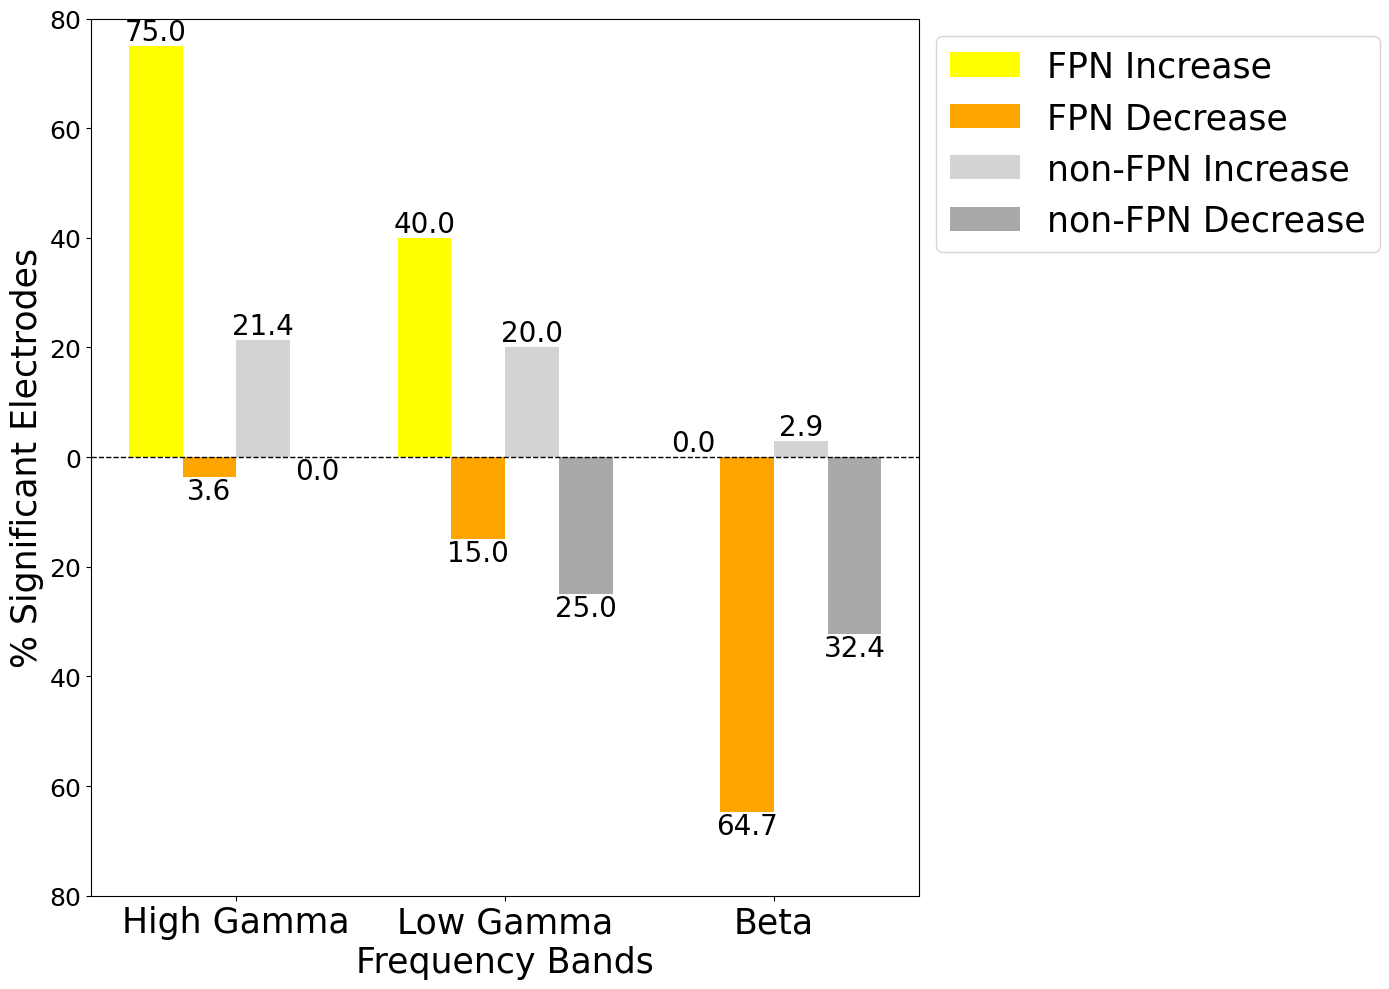

In [6]:
# Calculating data
results_hg = calculate_electrode_counts_networks(data_hg)
results_lg = calculate_electrode_counts_networks(data_lg)
results_beta = calculate_electrode_counts_networks(data_beta)

# Preparing data for plotting
categories = ['High Gamma', 'Low Gamma', 'Beta']
results_list = [results_hg, results_lg, results_beta]
index = np.arange(len(categories))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(14, 10))
colors = ['yellow', 'orange', 'lightgrey', 'darkgrey']
labels = ['FPN Increase', 'FPN Decrease', 'non-FPN Increase', 'non-FPN Decrease']

# Plotting bars with proper alignment
for i, results in enumerate(results_list):
    for j, label in enumerate(labels):
        key = label.lower().replace(" ", "_").replace("-", "_")
        value = results.get(key, 0)  # Retrieve correct value
        offset = index[i] + (j - 1.5) * bar_width  # Proper bar alignment

        # Plotting bar
        ax.bar(offset, value if 'increase' in key else -value, bar_width, color=colors[j], label=label if i == 0 else "")

        # Adding value label above and below bar
        ax.text(offset,
                value if 'increase' in key else -value,
                f'{value:.1f}',
                ha='center', va='bottom' if 'increase' in key else 'top',
                fontsize=20)

# Plot configuration
ax.set_xlabel('Frequency Bands', fontsize=25)
ax.set_ylabel('% Significant Electrodes', fontsize=25)
# ax.set_title('Percentage of Electrodes Showing Significant Power Changes by Network and Band', fontsize=15, pad=20)
ax.set_xticks(index)
ax.set_xticklabels(categories, fontsize=25)
ax.axhline(0, color='black', linewidth=1, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=25)
ax.set_ylim(-80, 80)
ax.set_yticks(range(-80, 81, 20))
ax.set_yticklabels([abs(tick) for tick in range(-80, 81, 20)], fontsize=18)


plt.tight_layout()
plt.show()


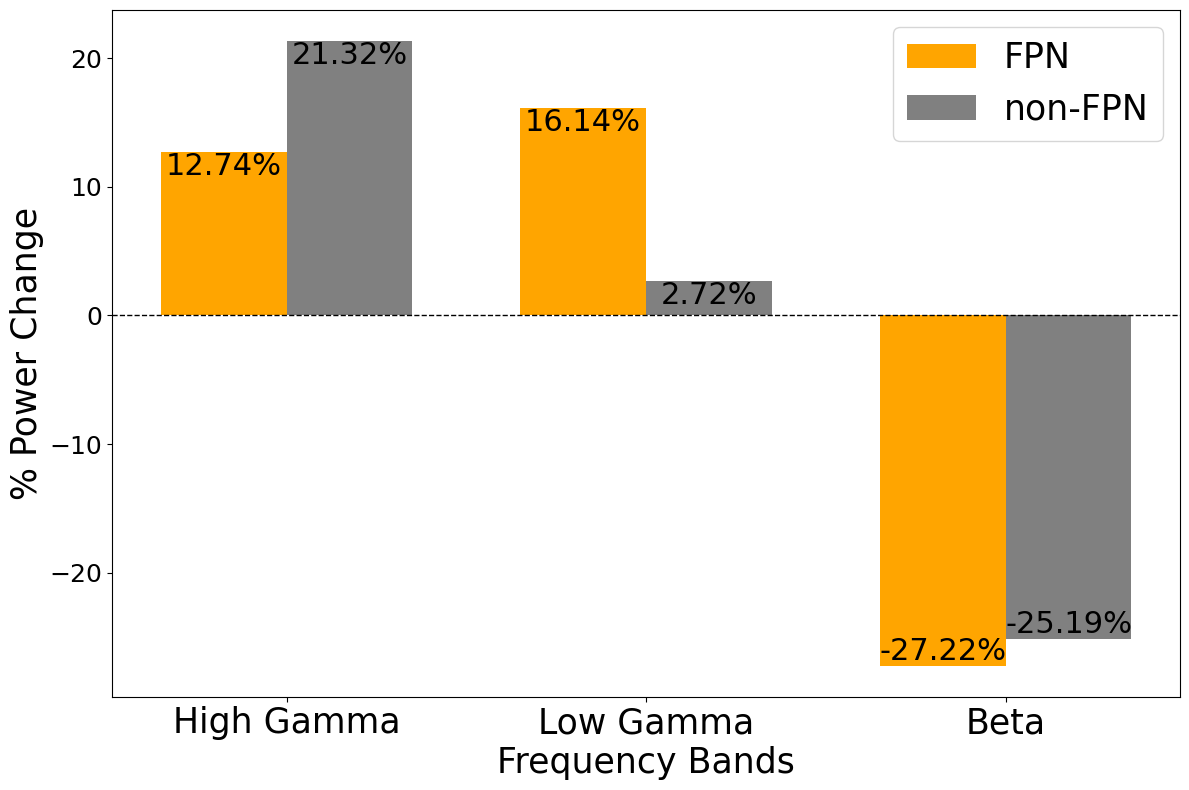

In [8]:
# Loading and preparing data
data_hg = load_data('Band5-HG Results.csv')
data_hg['Band'] = 'High Gamma'
data_lg = load_data('Band4-Gamma Results.csv')
data_lg['Band'] = 'Low Gamma'
data_beta = load_data('Band3-Beta Results.csv')
data_beta['Band'] = 'Beta'

# Combining and calculating net changes
combined_data = pd.concat([data_hg, data_lg, data_beta])
net_changes = calculate_net_changes(combined_data)

# Plotting net changes with value
fig, ax = plt.subplots(figsize=(12, 8))
colors = {'FPN': 'orange', 'non-FPN': 'grey'}
bands = ['High Gamma', 'Low Gamma', 'Beta']
network_types = ['FPN', 'non-FPN']

for i, band in enumerate(bands):
    for j, network in enumerate(network_types):
        value = net_changes.get(network, {}).get(band, 0)
        bar = ax.bar(i + j * 0.35, value, 0.35, color=colors[network], label=f'{network}' if i == 0 else '')
        ax.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(),
                f'{value:.2f}%', ha='center', va='bottom' if value < 0 else 'top', fontsize=22)

ax.set_ylabel('% Power Change', fontsize=25)
ax.set_xlabel('Frequency Bands', fontsize=25)
# ax.set_title(' Average power modulations of all significant electrodes within and outside the FPN for each frequency band')
ax.set_xticks(np.arange(len(bands)) + 0.35 / 2)
ax.set_xticklabels(bands, fontsize=25)
ax.legend(fontsize=25)
ax.axhline(0, color='black', linewidth=1, linestyle='--')
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


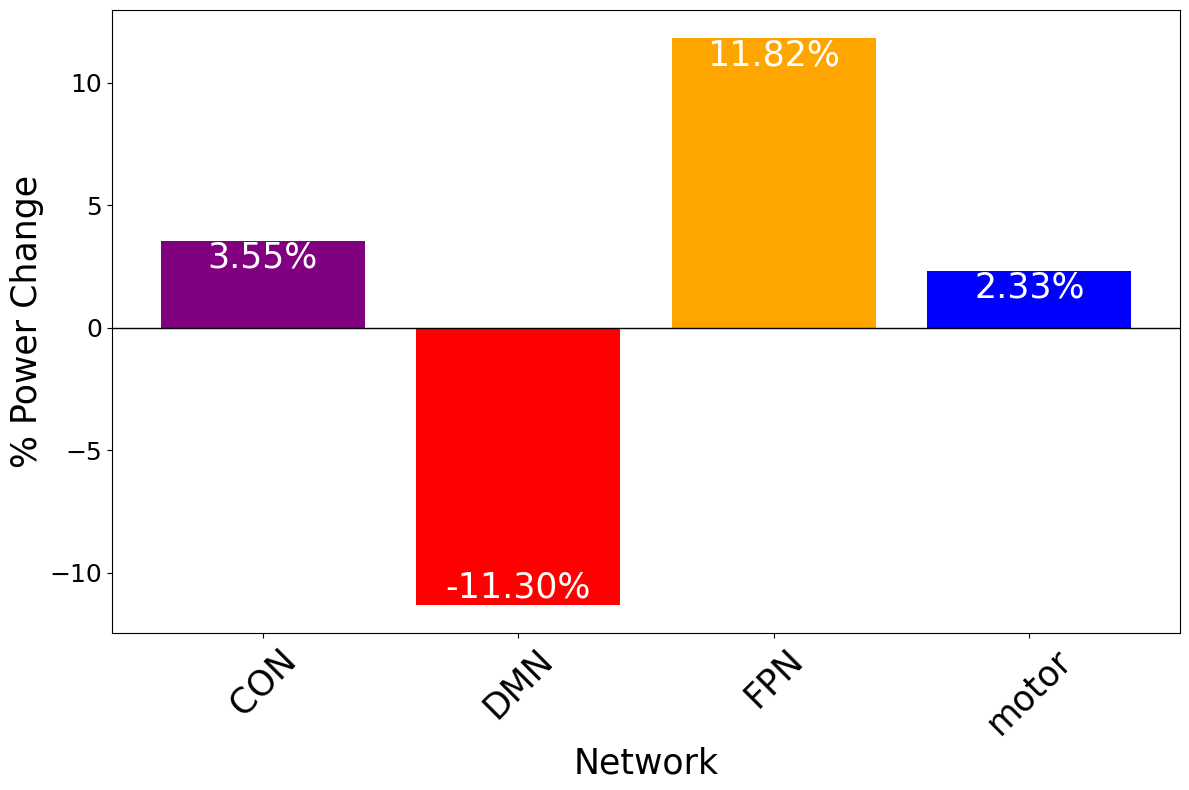

In [9]:
# Color mapping for each network
color_map = {
    'FPN': 'orange',
    'DMN': 'red',
    'CON': 'purple',
    'motor': 'blue'
}

high_gamma_data = pd.concat([
    data_hg
])


# Average changes
network_changes = calculate_average_changes(high_gamma_data)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
networks = network_changes['Network']
values = network_changes['PSC']

# Colors to each network
colors = [color_map[network] if network in color_map else 'gray' for network in networks]

bars = ax.bar(networks, values, color=colors)
ax.axhline(0, color='black', linewidth=1)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value, f'{value:.2f}%', ha='center', va='bottom' if value < 0 else 'top', color='white', fontsize=25)

ax.set_xlabel('Network', fontsize=25)
ax.set_ylabel('% Power Change', fontsize=25)
# ax.set_title('Average power modulations of all electrodes within each network ')
plt.xticks(rotation=45, fontsize=25)
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()
